# Sepsis Dataset

In [1]:
import pm4py
import pandas as pd
import sys
sys.path.append("../..")
from experiments.dataframetocapnp import dataframeToMessage
from experiments.dataframetocapnp import dataframeFromMessage

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/5e805b79fcb6ba4c2d23712967df89a089da575b


In [2]:
log = pm4py.read_xes("../datasets/Sepsis Cases - Event Log.xes")

/usr/local/lib/python3.9/dist-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2099.52it/s]


## Data exploration

In [3]:
log.shape

(15214, 32)

In [4]:
log.columns

Index(['InfectionSuspected', 'org:group', 'DiagnosticBlood', 'DisfuncOrg',
       'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion',
       'DiagnosticArtAstrup', 'concept:name', 'Age', 'DiagnosticIC',
       'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther',
       'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature',
       'time:timestamp', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos',
       'Oligurie', 'DiagnosticLacticAcid', 'lifecycle:transition', 'Diagnose',
       'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG',
       'case:concept:name', 'Leucocytes', 'CRP', 'LacticAcid'],
      dtype='object')

In [5]:
log.isna().sum()

InfectionSuspected           14164
org:group                        0
DiagnosticBlood              14164
DisfuncOrg                   14164
SIRSCritTachypnea            14164
Hypotensie                   14164
SIRSCritHeartRate            14164
Infusion                     14164
DiagnosticArtAstrup          14164
concept:name                     0
Age                          14164
DiagnosticIC                 14164
DiagnosticSputum             14164
DiagnosticLiquor             14164
DiagnosticOther              14164
SIRSCriteria2OrMore          14164
DiagnosticXthorax            14164
SIRSCritTemperature          14164
time:timestamp                   0
DiagnosticUrinaryCulture     14164
SIRSCritLeucos               14164
Oligurie                     14164
DiagnosticLacticAcid         14164
lifecycle:transition             0
Diagnose                     14417
Hypoxie                      14164
DiagnosticUrinarySediment    14164
DiagnosticECG                14164
case:concept:name   

In [6]:
log["concept:name"]

0         ER Registration
1              Leucocytes
2                     CRP
3              LacticAcid
4               ER Triage
               ...       
15209                 CRP
15210           Release A
15211     ER Registration
15212           ER Triage
15213    ER Sepsis Triage
Name: concept:name, Length: 15214, dtype: object

In [7]:
len(set(log["concept:name"]))

16

Looks like activity names.

In [8]:
len(set(log["case:concept:name"]))

1050

These are probably the case IDs.

In [9]:
log.sort_values("time:timestamp", axis="rows", inplace=True)

Ensure that events are correctly ordered through time.

In [10]:
set(log["lifecycle:transition"])

{'complete'}

In [11]:
log.drop(["lifecycle:transition", "time:timestamp"], axis="columns", inplace=True)

Remove columns that are useless for learning data modification rules.

## Convert to capnp message

In [12]:
import capnp
capnp.remove_import_hook()
interface_capnp = capnp.load("../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

In [13]:
eventLogMessage = dataframeToMessage(log, fillMissingValues=True)

Constructing traces: 100%|██████████| 1050/1050 [00:09<00:00, 109.44it/s]


### Testing reverse direction

In [14]:
reconstructedLog = dataframeFromMessage(eventLogMessage)

100%|██████████| 1050/1050 [00:00<00:00, 4507.28it/s]


In [15]:
log.sort_values("case:concept:name", axis="rows", inplace=True, kind="stable")
reconstructedLog.sort_values("case:concept:name", axis="rows", inplace=True, kind="stable")
log = log.reindex(sorted(log.columns), axis=1)
reconstructedLog = reconstructedLog.reindex(sorted(reconstructedLog.columns), axis=1)
log.reset_index(drop=True, inplace=True)
reconstructedLog.reset_index(drop=True, inplace=True)
log.equals(reconstructedLog)

True

## Finding model of data modification rules

In [16]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [17]:
modelPromise = processDataUpdates.findModel(eventLogMessage)
foundModel = modelPromise.wait().model
print(processDataUpdates.modelToString(foundModel).wait().string)

IF TRUE THEN Age = Age_prev + 0.000000
IF NOT (concept:name = CRP) THEN CRP = CRP_prev + 0.000000
IF DisfuncOrg = True THEN Diagnose IN {G}
IF SIRSCriteria2OrMore = False THEN DiagnosticArtAstrup IN {False}
IF DiagnosticIC = False THEN DiagnosticBlood IN {False}
IF DiagnosticXthorax = False THEN DiagnosticECG IN {False}
IF SIRSCriteria2OrMore = False THEN DiagnosticIC IN {False}
IF DiagnosticIC = False THEN DiagnosticLacticAcid IN {False}
IF DiagnosticUrinarySediment = False THEN DiagnosticLiquor IN {False}
IF DiagnosticXthorax = False THEN DiagnosticSputum IN {False}
IF DiagnosticUrinarySediment = False THEN DiagnosticUrinaryCulture IN {False}
IF DiagnosticIC = False THEN DiagnosticUrinarySediment IN {False}
IF DiagnosticIC = False THEN DiagnosticXthorax IN {False}
IF Hypotensie = True THEN DisfuncOrg IN {True}
IF Oligurie = True THEN Hypotensie IN {True}
IF DiagnosticECG = False THEN Hypoxie IN {False}
IF SIRSCriteria2OrMore = False THEN InfectionSuspected IN {False}
IF SIRSCriteria2

With the MDL score estimate, the search finishes in 1h 46min 30.2s. Without estimate it took 2h 31min 47.6s. There are many identical update rules, whose conditions could be combine with OR operators.

### Debug output

## Further analysis

### Age distribution

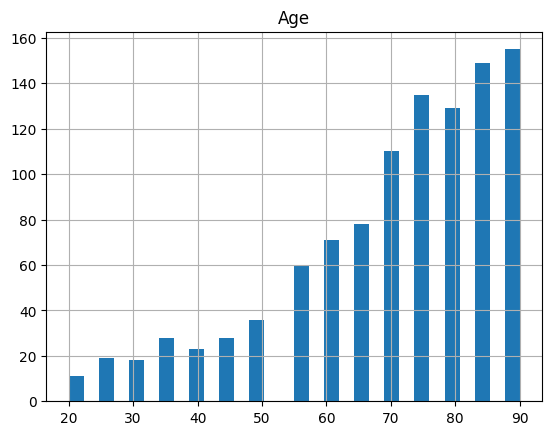

In [36]:
_ = log[["case:concept:name", "Age"]].groupby("case:concept:name").mean().hist(bins=30)

### Leucocytes rule

In [24]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < leucocytesModel.json > /tmp/leucocytesModel.bin
with open("/tmp/leucocytesModel.bin", "rb") as file:
    leucocytesModel = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(leucocytesModel).wait().string)

IF 1.200000 <= Leucocytes THEN concept:name IN {Leucocytes}
IF Leucocytes <= 34.200000 THEN concept:name IN {Leucocytes}



In [25]:
processDataUpdates.calculateMdlScore(eventLogMessage, leucocytesModel).wait().result

161643.28839792378

| Model | Rounded Score |
| ----- | ------------: |
| IF 1.200000 <= Leucocytes THEN concept:name IN {Leucocytes} | 158472 |
| IF Leucocytes <= 34.200000 THEN concept:name IN {Leucocytes} | 158478 |
| IF (Leucocytes <= 34.200000) AND (1.200000 <= Leucocytes) THEN concept:name IN {Leucocytes} | 158666 |
| IF 1.200000 <= Leucocytes THEN concept:name IN {Leucocytes} <br> IF Leucocytes <= 34.200000 THEN concept:name IN {Leucocytes} | 161643 |
| \<empty model\> | 165552 |

It doesn't seem to be a range condition for "Leucocytes". At least the MDL score is higher.

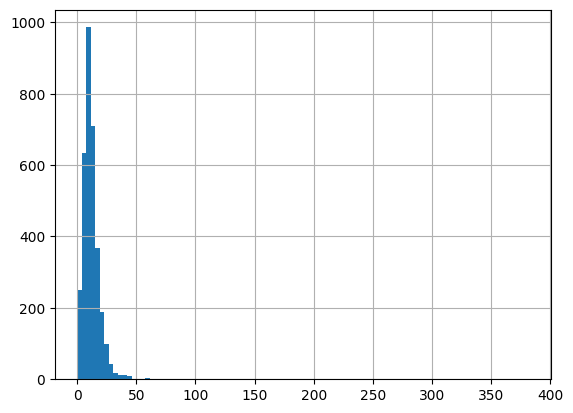

In [35]:
_ = log[log["concept:name"] == "Leucocytes"]["Leucocytes"].hist(bins=100)

In [42]:
log[log["concept:name"] == "Leucocytes"]["Leucocytes"].count()

3361

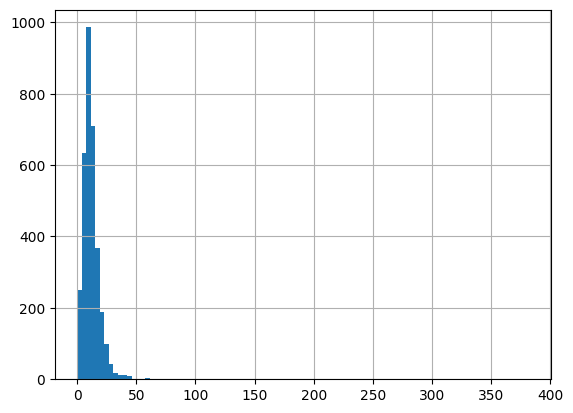

In [36]:
_ = log["Leucocytes"].hist(bins=100)

In [41]:
log["Leucocytes"].count()

3361

The higher MDL score makes sense since the distributions do not differ between the activity "Leucocytes" and globally. In fact, the "Leucocytes" value only occurs at the activity "Leucocytes". Thus, the rule essentially says "If you observe any leucocytes value you will also observe the leucocytes activity".